# import

In [1]:
import numpy as np
import pandas as pd
# import scipy.io
# from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# from tqdm import tqdm
import os
import pickle

%load_ext autoreload
%autoreload 2

In [2]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

# load mix50
mix50 stim: Z:\All_Staff\home\lan\Mwork\mix50 - bunnytop high lum contrast mix grating and noise\Image

In [14]:
if local_flag:
    dir_data = r'D:\repo\inter_data\mix50\V1_i1373_220909_cellpose'
else:
    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\mix50_data/'

# Create a dictionary with keys being recording folder name, and value -- array with first element being stimulus identity array, and second element -- trace by trial matrix; 
recordings = {f : [adp.load_trace_trial_data(os.path.join(dir_data, f), vis_filter=True)] for f in os.listdir(dir_data) if os.path.isdir(os.path.join(dir_data, f))}

# Calculate the minimum number of trials for each trial id across recordings and store in a dictionary with trial id as the key, and smallest number of trials as a value
min_trial_num = {}
for recording in recordings.keys():
    si, tbt = recordings[recording][0]
    names, counts = np.unique(si, return_counts=True)
    for i, n in enumerate(names):
        if n not in min_trial_num.keys() or counts[i] < min_trial_num[n]:
            min_trial_num[n] = counts[i]

ncell: 169, nstim: 50, ntrial: 1473, nframe: 203
ncell: 110, nstim: 50, ntrial: 1473, nframe: 203
ncell: 206, nstim: 50, ntrial: 1473, nframe: 203


In [5]:
#out_tbt is the final merged array
out_tbt = np.array([])
trialids = min_trial_num.keys()

for recording in recordings.keys():
    #for each recording, re-create trace-by-trial matrix with trial ids sorted the same way across recordings
    out_tbt_by_recording = np.array([])
    for trial_id in trialids:
        min_num_trials = min_trial_num[trial_id]
        # print(min_num_trials)
        si, tbt = recordings[recording][0]
        #select the trials where the current trial_id is used and use that to index
        curr_trialid_locs = np.where(si == trial_id)[0][:min_num_trials]
        # print(curr_trialid_locs.shape)
        # print('\n')

        tbt_slice = tbt[:, curr_trialid_locs, :]
        if out_tbt_by_recording.shape[0] == 0:
            out_tbt_by_recording = tbt_slice
        else:
            #stack trace-by-trial matrices along 1st dimension (n trial)
            out_tbt_by_recording = np.hstack((out_tbt_by_recording, tbt_slice))
    #stack trace-by-trial matrices along 0th dimesion (neuron)
    if out_tbt.shape[0] == 0:
        out_tbt = out_tbt_by_recording
    else:
        out_tbt = np.vstack((out_tbt, out_tbt_by_recording))

print(out_tbt.shape)

(485, 1444, 203)


In [6]:
stim_id_merged = np.array([])
for trial_id in trialids:
    min_num_trials = min_trial_num[trial_id]
    for i in range(min_num_trials):
        stim_id_merged = np.append(stim_id_merged, int(trial_id))
stim_id_merged = stim_id_merged.astype(int)

# count stim_id_merged elements
np.unique(stim_id_merged, return_counts=True)
stim_id_merged.shape

(1444,)

trace_cell_avg: (203,).         trace_stim_avg list len: 50.         trace_stim_avg[0].shape: (203,)


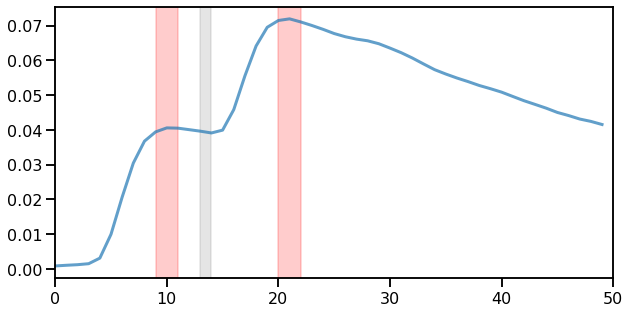

In [7]:
trace_by_trial = out_tbt
stim_id = stim_id_merged
trace_avg_cell, trace_cell_sem, trace_stim_avg = adp.calc_trace_stim(trace_by_trial, stim_id)

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(trace_avg_cell[:50], alpha=0.7, linewidth=3)
ax.axvspan(9,11, alpha=0.2, color='red')
ax.axvspan(13,14, alpha=0.2, color='gray')
ax.axvspan(20,22, alpha=0.2, color='red')
plt.xlim(0, 50);

In [11]:
stim_type_dict = {'natural': [np.arange(1, 30+1)], 
                  'grat': [np.arange(31, 40+1)], 
                  'noise': [np.arange(41, 50+1)]}
for key in stim_type_dict.keys():
    print(key, np.min(stim_type_dict[key]), '-', np.max(stim_type_dict[key]))

natural 1 - 30
grat 31 - 40
noise 41 - 50


(3, (203,))

In [15]:
# get resp_ad and resp_tg [cell x trial]
base1 = trace_by_trial[:,:,0:2+1].mean(axis=2) # avg over time window frames
resp_ad = trace_by_trial[:,:,9:11+1].mean(axis=2)
resp_ad = resp_ad - base1

base2 = trace_by_trial[:,:,13:14+1].mean(axis=2)
resp_tg = trace_by_trial[:,:,20:22+1].mean(axis=2)
resp_tg = resp_tg - base2

resp_ad.shape, resp_tg.shape

((485, 1444), (485, 1444))

## vis, img driven, pref filter
merged mix50 data only support 'vis' filter for now

In [16]:
img_driven_merge = np.array([])

for subdir in os.listdir(dir_data):
    data_dir = os.path.join(dir_data, subdir)
    print(data_dir)

    with open(data_dir + "/vis_driven.pickle", "rb") as handle:
        vis = pickle.load(handle)
    vis_driven = vis["vis_driven"]
    vis_driven = [v[0] for v in vis_driven]

    img_driven = vis['img_driven'][vis_driven, :]
    print(img_driven.shape)
    img_driven_merge = img_driven if img_driven_merge.size == 0 else np.concatenate((img_driven_merge, img_driven))

img_driven = img_driven_merge
img_driven.shape

\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\mix50_data/V1_i1373_220909_cellpose
(169, 50)
\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\mix50_data/V1_i1374_220907_cellpose
(110, 50)
\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\mix50_data/V1_i1375_220915_cellpose
(206, 50)


(485, 50)

img_driven
(485, 50)
0 out of 50 stims have no cells passing filter
86 out of 485 cells have no stim passing filter


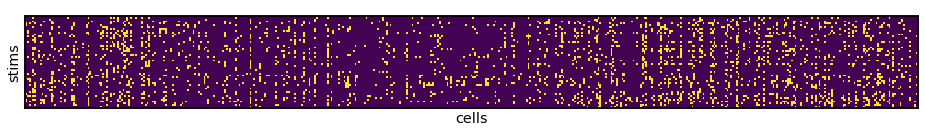

In [20]:
cell_filter_name = 'img_driven'
print(cell_filter_name)
if cell_filter_name == 'img_driven': # only use img driven cells
    cell_filter = img_driven
# elif cell_filter_name == 'pref_filter': # only use cells preferring each img
#     pref_filter = np.load(data_dir + "/pref_filter.npy") # load pref_filter.npy, constructed under img driven filter
#     cell_filter = pref_filter.copy().T
elif cell_filter_name == 'vis': # use all vis driven cells
    cell_filter = np.ones_like(img_driven)
else:
    raise ValueError('cell_filter not recognized')

plt.matshow(cell_filter.T)
plt.xticks([]) # no axis ticks
plt.yticks([])
plt.xlabel('cells')
plt.ylabel('stims');

print(cell_filter.shape) # ncell x nstim
print(f'{np.sum(cell_filter.sum(axis=0) == 0)} out of {cell_filter.shape[1]} stims have no cells passing filter')
print(f'{sum(cell_filter.sum(axis=1) == 0)} out of {cell_filter.shape[0]} cells have no stim passing filter')

C:\Users\ll357\AppData\Local\Temp\10\ipykernel_18132\2775581966.py:27: RuntimeWarning: Mean of empty slice
  resp_ad_stim_cell = np.array([np.nanmean(i, axis=1) for i in resp_ad_by_stim]) # [ncell x nstim], sum over trial reps


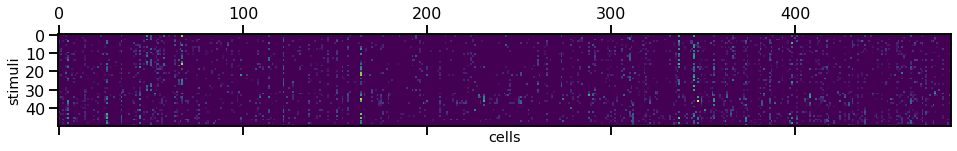

In [279]:
def resp_by_stim(resp_ad, resp_tg, cell_filter, stim_id):
    '''
    reshape resp_ad and resp_tg by stim: nstim x [ncell x trial_rep]
    enable stim_id to be modified, so we can bin spatial freq of gratings
    '''

    resp_ad_by_stim = []
    resp_tg_by_stim = []

    for istim in np.unique(np.sort(stim_id)):
        istim_id = np.where(stim_id == istim)[0] # which trial has this stim
        
        resp_ad_istim = resp_ad[:, istim_id]
        resp_ad_istim[cell_filter[:, istim-1] == False, :] = np.nan # stim id starts from 1, but index starts from 0
        # TODO: comment line above if using mix50 merged data
        resp_ad_by_stim.append(resp_ad_istim)
        
        resp_tg_istim = resp_tg[:, istim_id]
        resp_tg_istim[cell_filter[:, istim-1] == False, :] = np.nan
        resp_tg_by_stim.append(resp_tg_istim)

    return resp_ad_by_stim, resp_tg_by_stim

resp_ad_by_stim, resp_tg_by_stim = resp_by_stim(resp_ad, resp_tg, cell_filter, stim_id)
# len(resp_ad_by_stim), [i.shape for i in resp_ad_by_stim[:5]]
# resp_ad_by_stim[0].shape, len(resp_ad_by_stim) # ncell x ntrial_rep x nstim
resp_ad_stim_cell = np.array([np.nanmean(i, axis=1) for i in resp_ad_by_stim]) # [ncell x nstim], sum over trial reps
resp_ad_stim_cell.shape # nstim x ncell

resp_ad_cell_stim = resp_ad_stim_cell.T
resp_ad_cell_stim.shape # ncell x nstim, aka nsample x nfeature
resp_ad_cell_stim[np.isnan(resp_ad_cell_stim)] = 0 # substitute nan with 0, to accomodate hierarchical clustering
plt.matshow(resp_ad_cell_stim.T)
plt.xlabel('cells')
plt.ylabel('stimuli');

## hierarchical clustering
find neurons w similar resp profile or adp profile  
compare neuron clustering based on resp vs adp

In [280]:
# source: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

    return linkage_matrix

### grating tuning cluster

In [281]:
def cluster_stim_resp(distance_threshold, resp_stim_type, nlevel_visible, stim_type_str):
    model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=None, compute_distances=False) # set distance_threshold to non zero to get model.labels_ usable - we dont want every cell to be its own cluster
    model = model.fit(resp_stim_type)

    _, axes = plt.subplots(1, 1, figsize=(20, 10))
    _ = plot_dendrogram(model, ax=axes, truncate_mode="level", p=nlevel_visible, count_sort='descending', leaf_rotation=90, leaf_font_size=12) # plot the first p levels of the dendrogram
    plt.title(f"Hierarchical Clustering Dendrogram, {stim_type_str}")
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.ylabel('Distance');
    plt.savefig(f'dendrogram_{stim_type_str}_tuning.pdf')

    print(type(model))
    return model

<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>


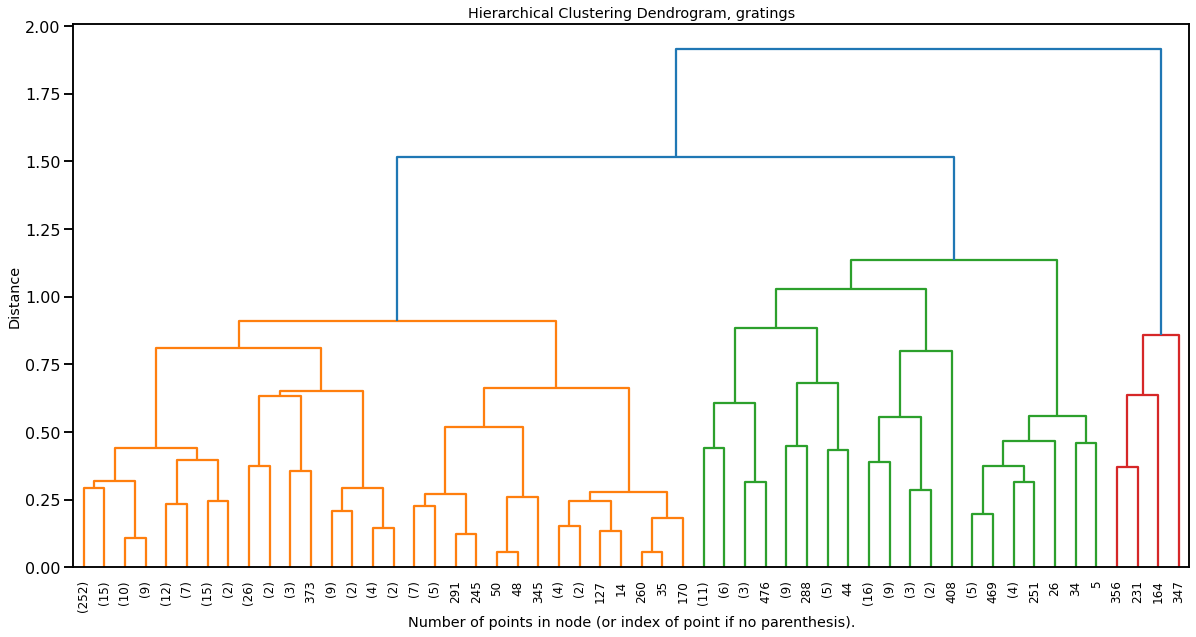

In [293]:
resp_grat = resp_ad_cell_stim[:, 30:40]
model_grat = cluster_stim_resp(0.25, resp_grat, 6, 'gratings')

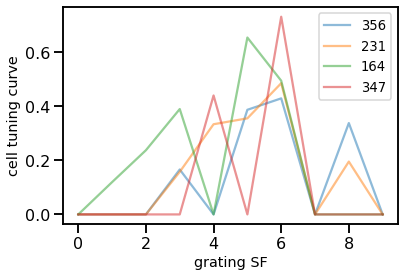

In [283]:
outlier_cells = np.array([356, 231, 164, 347])
for icell in outlier_cells:
    plt.plot(resp_grat[icell, :], alpha=0.5, label=str(icell))
plt.legend()
plt.xlabel('grating SF')
plt.ylabel('cell tuning curve');

In [295]:
def plot_cluster_tuning(model, resp_stim_type, stim_type_str, sharexy=True, ncol=5, figsize=(15, 15)):

    nsubplot = len(np.unique(model.labels_))
    nrow = nsubplot // ncol + 1 # set 5 columns, n rows

    if sharexy:
        _, ax = plt.subplots(nrow, ncol, figsize=figsize, sharex=True, sharey=True)
    else:
        _, ax = plt.subplots(nrow, ncol, figsize=figsize)

    # sort clusters by size
    cluster_size = np.array([len(np.where(model.labels_ == i)[0]) for i in np.unique(model.labels_)])
    cluster_size_sort = np.argsort(cluster_size)[::-1]
    cluster_size_sort = np.unique(model.labels_)[cluster_size_sort] # cluster id sorted by size

    for isubplot, ilabel in enumerate(cluster_size_sort): # for each cluster, subplot sorted by cluster size
        # plot the mean tuning curve across cells in a subplot
        resp_grat_agg = np.mean(resp_stim_type[model.labels_ == ilabel, :], axis=0) # set nan to 0 before, so should use mean but not median
        ax[isubplot // ncol, isubplot % ncol].plot(resp_grat_agg, linewidth=4, color='cyan', alpha=0.8)

        # plot the tuning curve of each cell in the cluster
        for icell in np.where(model.labels_ == ilabel)[0]:
            ax[isubplot // ncol, isubplot % ncol].plot(resp_stim_type[icell, :], alpha=0.5, linestyle='--', linewidth=1)

        # add scale bar on the left, if not sharex and sharey
        if not sharexy:
            scale_bar_len = (np.amax(resp_stim_type) - np.amin(resp_stim_type)) * 0.1
            ax[isubplot // ncol, isubplot % ncol].plot([-1, -1], [0, scale_bar_len], linewidth=5, color='gray')

        # add text annotation of cluster id & cell number
        ax[isubplot // ncol, isubplot % ncol].text(0, 1, f'cluster {isubplot}, ncell={np.sum(model.labels_ == ilabel)}', transform=ax[isubplot // ncol, isubplot % ncol].transAxes, fontsize=12, verticalalignment='bottom')

        ax[isubplot // ncol, isubplot % ncol].set_xticks([])
        ax[isubplot // ncol, isubplot % ncol].set_yticks([])
        ax[isubplot // ncol, isubplot % ncol].spines['top'].set_visible(False) # turn off top and right spines
        ax[isubplot // ncol, isubplot % ncol].spines['right'].set_visible(False)
        ax[isubplot // ncol, isubplot % ncol].spines['left'].set_visible(False)

    # hide subplots that are not used
    for i in range(nsubplot, nrow * ncol):
        ax[i // ncol, i % ncol].axis('off')

    plt.suptitle(f'Clustered {stim_type_str} tuning curves', fontsize=14, y=0.99)
    plt.tight_layout()
    plt.savefig(f'cluster_{stim_type_str}_tuning.pdf')

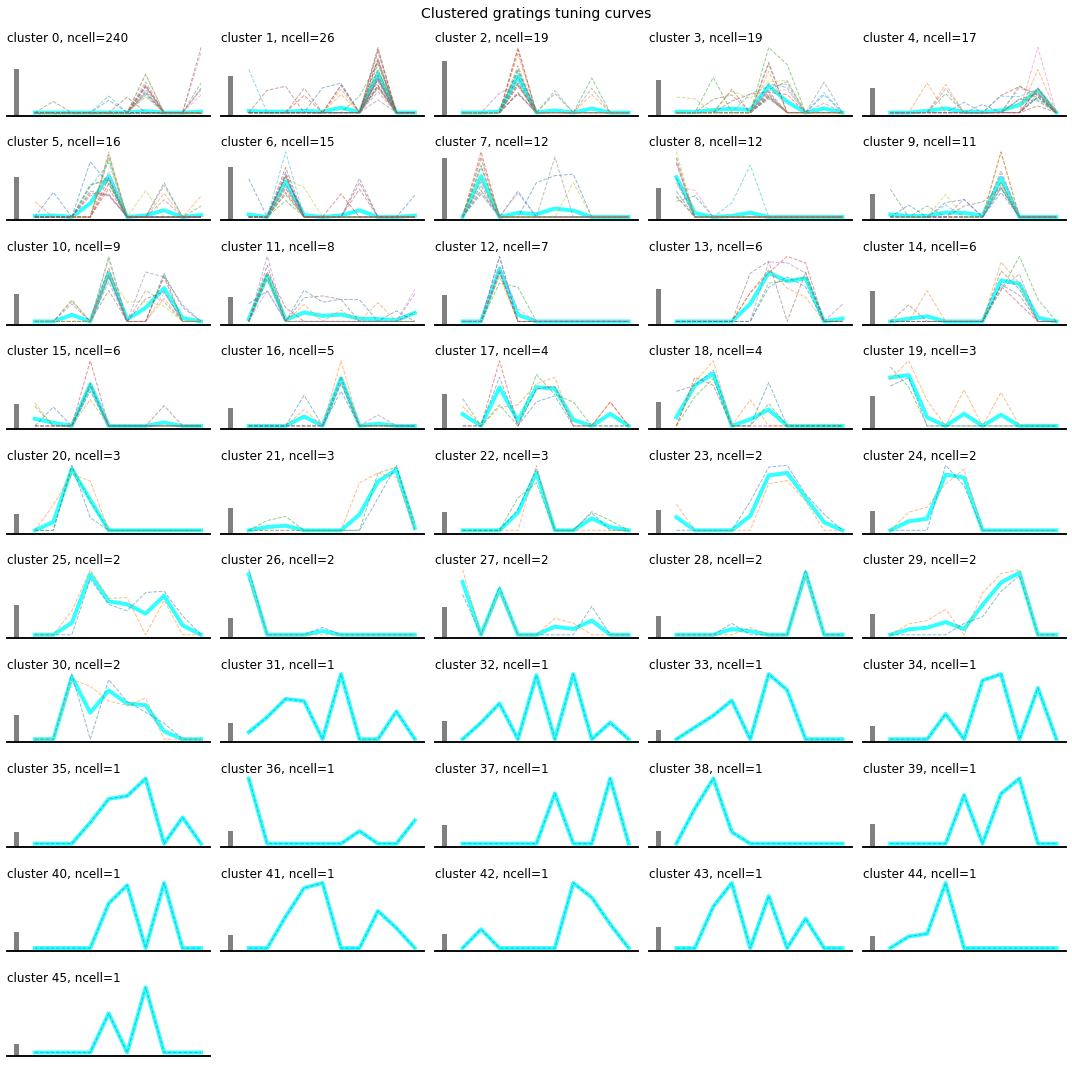

In [296]:
plot_cluster_tuning(model_grat, resp_grat, 'gratings', sharexy=False)

### noise tuning cluster

<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>


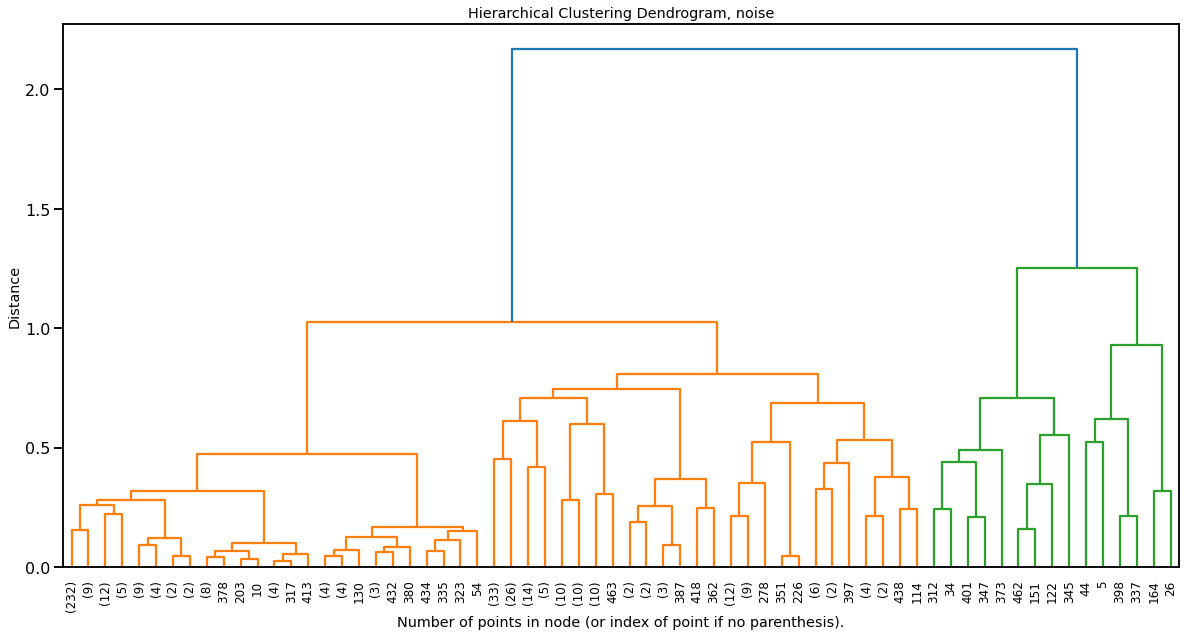

In [297]:
resp_noise = resp_ad_cell_stim[:, 40:]
model_noise = cluster_stim_resp(0.25, resp_noise, 6, 'noise')

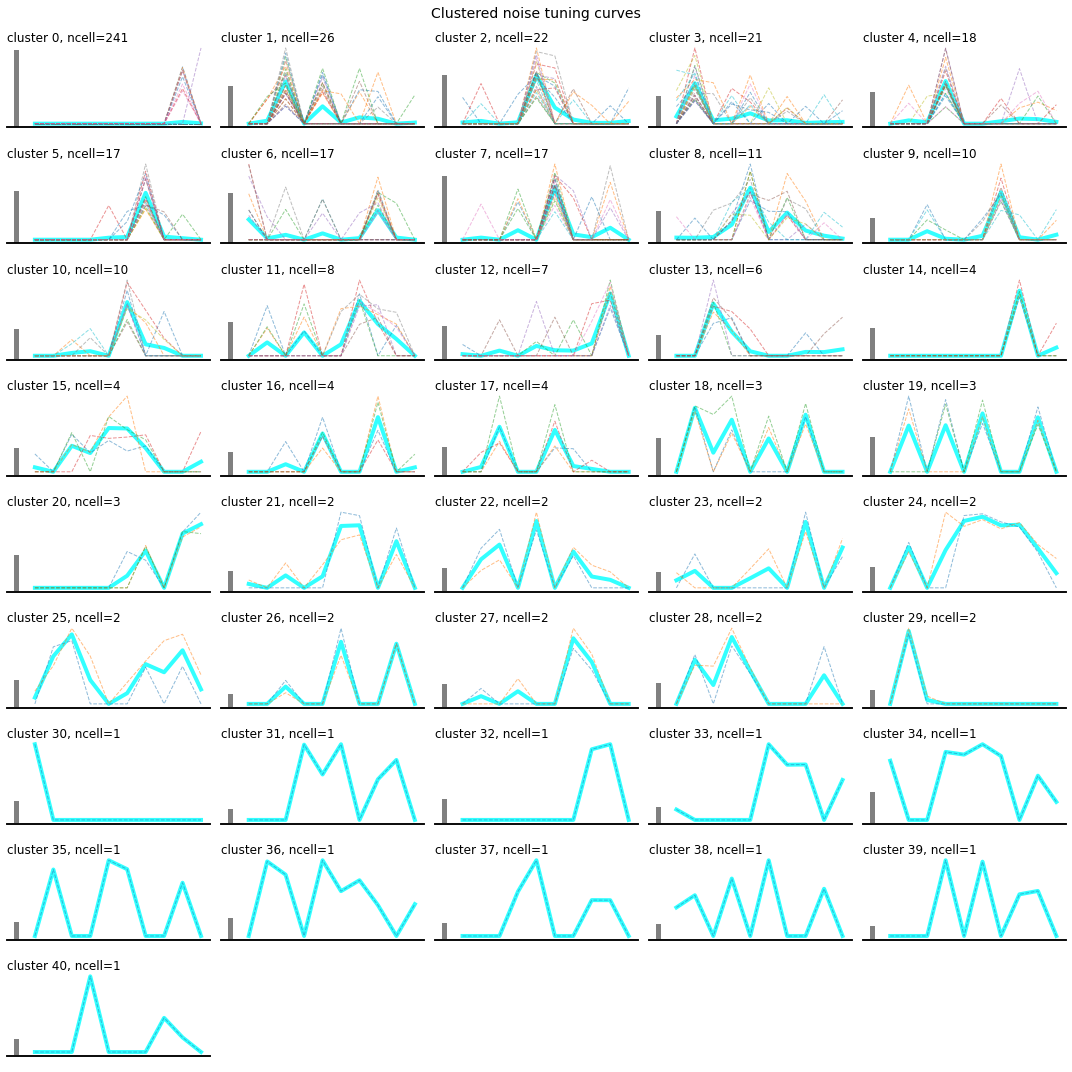

In [298]:
plot_cluster_tuning(model_noise, resp_noise, 'noise', sharexy=False)

### natural image tuning cluster

<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>


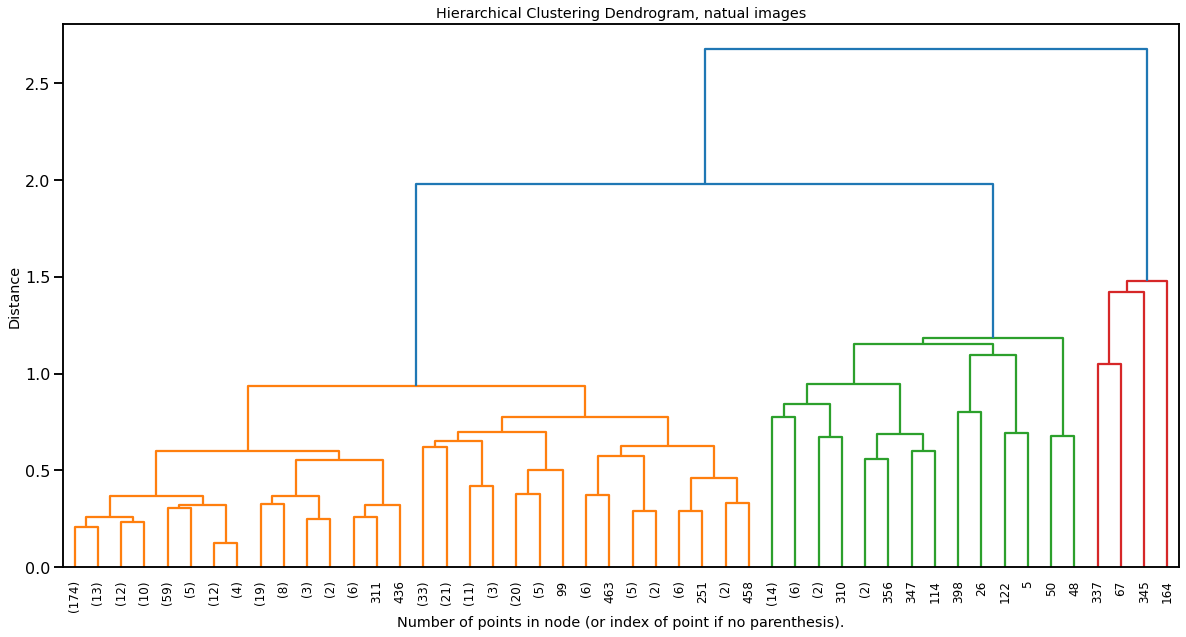

In [303]:
resp_nat = resp_ad_cell_stim[:, :30]
model_nat = cluster_stim_resp(0.25, resp_nat, 6, 'natual images')

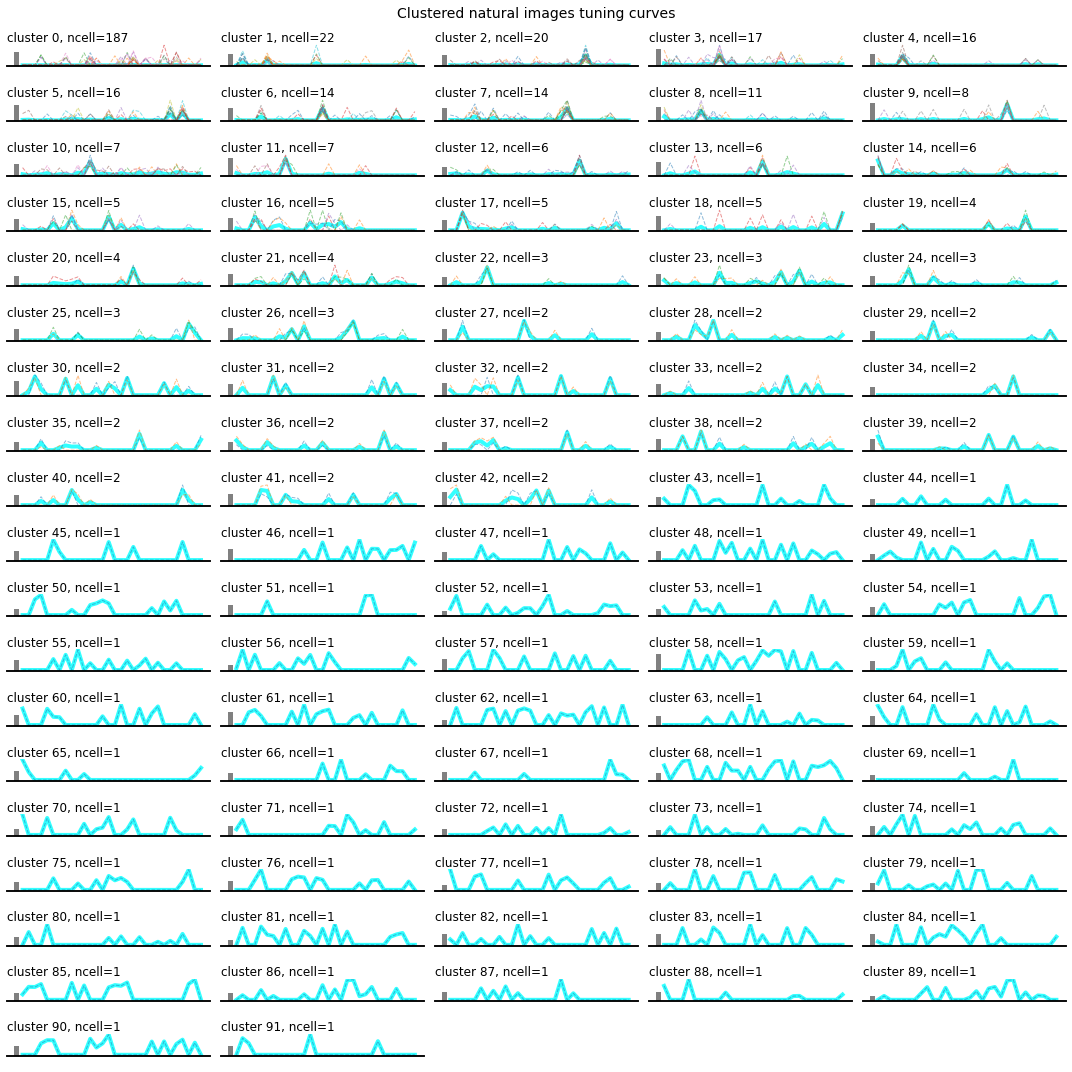

In [304]:
plot_cluster_tuning(model_nat, resp_nat, 'natural images', sharexy=False)

### special cells

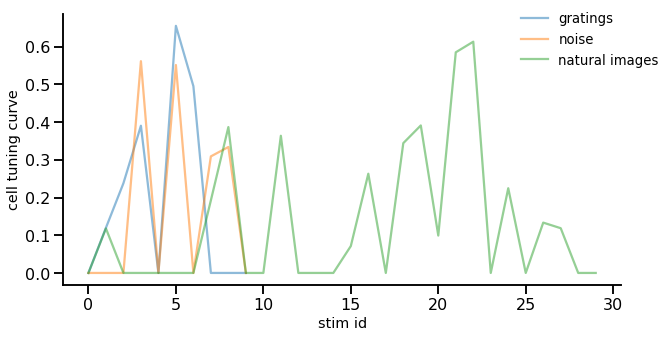

In [306]:
outlier_cells = np.array([164, ]) # 347

plt.figure(figsize=(10, 5))
plt.plot(resp_grat[icell, :], alpha=0.5, label='gratings')
plt.plot(resp_noise[icell, :], alpha=0.5, label='noise')
plt.plot(resp_nat[icell, :], alpha=0.5, label='natural images')
    
plt.legend(frameon=False, bbox_to_anchor=(0.8, 1.05))
plt.xlabel('stim id')
plt.ylabel('cell tuning curve');
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

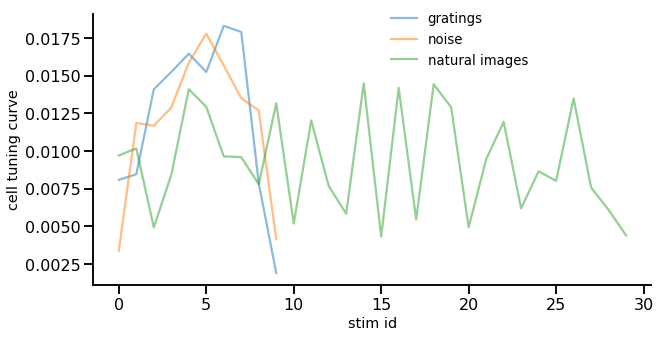

In [307]:
all_cells_exclude_outlier = np.setdiff1d(np.arange(resp_ad_cell_stim.shape[0]), outlier_cells)
resp_grat_exclude_outlier = resp_grat[all_cells_exclude_outlier, :].mean(axis=0)
resp_noise_exclude_outlier = resp_noise[all_cells_exclude_outlier, :].mean(axis=0)
resp_nat_exclude_outlier = resp_nat[all_cells_exclude_outlier, :].mean(axis=0)

plt.figure(figsize=(10, 5))
plt.plot(resp_grat_exclude_outlier, alpha=0.5, label='gratings')
plt.plot(resp_noise_exclude_outlier, alpha=0.5, label='noise')
plt.plot(resp_nat_exclude_outlier, alpha=0.5, label='natural images')

plt.legend(frameon=False, bbox_to_anchor=(0.8, 1.05))
plt.xlabel('stim id')
plt.ylabel('cell tuning curve');
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

### all stim tuning cluster

<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>


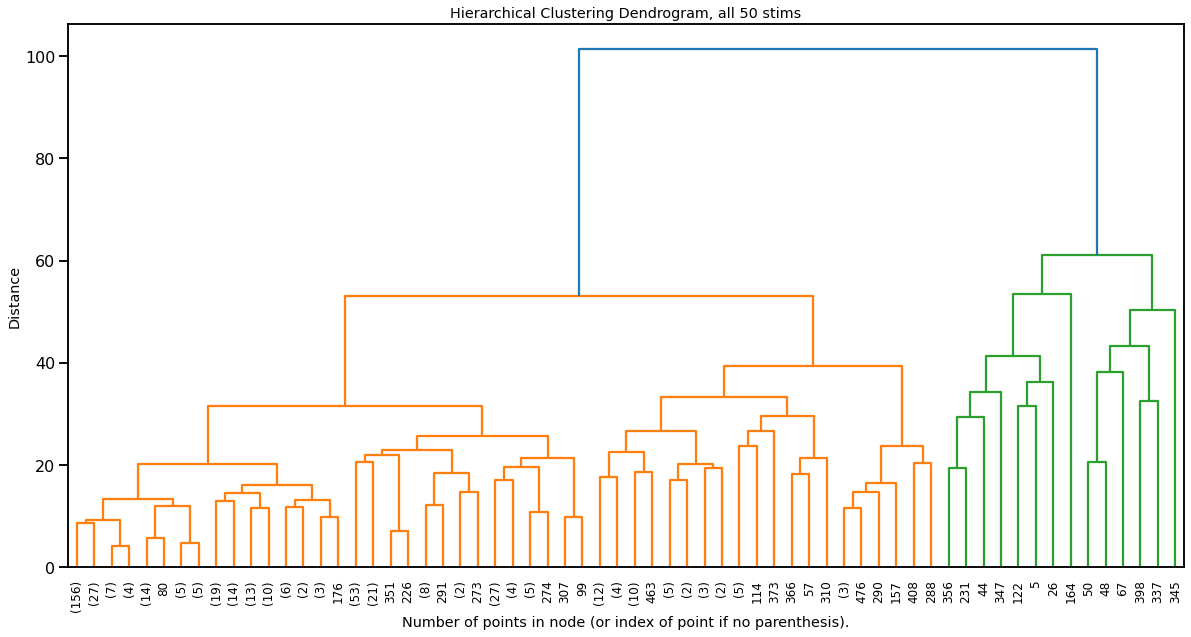

In [256]:
resp_all = resp_ad_cell_stim
model_all = cluster_stim_resp(10, resp_all, 6, 'all 50 stims')

In [237]:
# plot_cluster_tuning(model_all, resp_all, 'all', sharexy=False, ncol=3, figsize=(15, 10))
# # tight_layout cannot make axes height small enough to accommodate all axes decorations.

C:\Users\ll357\AppData\Local\Temp\10\ipykernel_18132\1710869880.py:4: RuntimeWarning: invalid value encountered in true_divide
  resp_ad_cell_stim_sorted = (resp_ad_cell_stim - np.nanmean(resp_ad_cell_stim, axis=1, keepdims=True)) / np.nanstd(resp_ad_cell_stim, axis=1, keepdims=True)


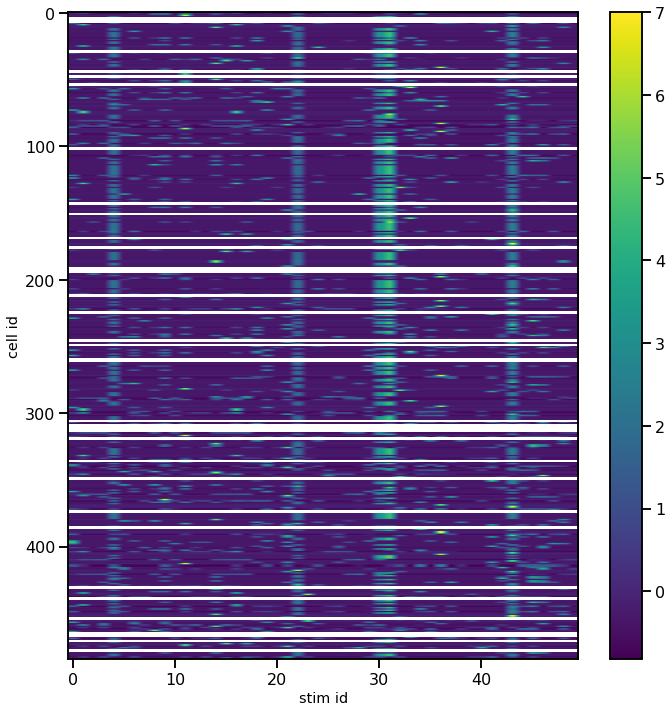

In [274]:
# imshow resp_ad_cell_stim after sorting cells by cluster

# z score resp_ad_cell_stim
resp_ad_cell_stim_sorted = (resp_ad_cell_stim - np.nanmean(resp_ad_cell_stim, axis=1, keepdims=True)) / np.nanstd(resp_ad_cell_stim, axis=1, keepdims=True)
resp_ad_cell_stim_sorted = resp_ad_cell_stim_sorted[model_all.labels_, :]
plt.figure(figsize=(10, 10))
plt.imshow(resp_ad_cell_stim_sorted, aspect='auto', cmap='viridis')
plt.colorbar()
plt.xlabel('stim id')
plt.ylabel('cell id')
# plt.title('resp_ad_cell_stim_sorted')
plt.tight_layout()